In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import numpy as np
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
import xml.etree.ElementTree as ET

## Functions

In [2]:
def equi_filled(map_axis, centerlon, centerlat, radius, color, alpha=1.0):
    """
    Modified from the ipmag function equi().
    """
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = ipmag.shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    
    X = X[::-1]
    Y = Y[::-1]
    
    XY = np.stack([X,Y],axis=1)
    
    circle_edge = patches.Polygon(XY,
                                  edgecolor=color,facecolor='none',
                                  transform=ccrs.Geodetic())
    circle_face = patches.Polygon(XY,
                                  edgecolor='none',facecolor=color,alpha=alpha,
                                  transform=ccrs.Geodetic())
    
    map_axis.add_patch(circle_face)
    map_axis.add_patch(circle_edge)

In [3]:
def get_craton_XYs(gpml, plateIDs):
    """
    Get XY coordinates of a plate polygon from a .gpml.
    
    Parameters
    ----------
    gpml : string
        Path to .gpml file.
        
    plateIDs : list
        Of plateIDs.
    """
    # namespace dictionary
    ns = {'gpml':'http://www.gplates.org/gplates',
          'gml':'http://www.opengis.net/gml'}
    
    # initial parse
    tree = ET.parse(gpml)
    root = tree.getroot()
    
    # storage
    Xs = []
    Ys = []
    
    # iterate through featureMembers
    for featureMember in root.findall('gml:featureMember',ns):
        
        # get child
        for child in featureMember:
            slice_ind = child.tag.find('}')
            child_root = 'gpml:' + child.tag[slice_ind+1:]
        
        # check plateID
        plateID_path = child_root + '/gpml:reconstructionPlateId/gpml:ConstantValue/gpml:value'
        feature_plateID = int(featureMember.find(plateID_path,ns).text)
        if feature_plateID in plateIDs:
            
            if featureMember.find(child_root + '/gpml:outlineOf', ns)!=None:
                polygon_root = child_root + '/gpml:outlineOf'
            elif featureMember.find(child_root + '/gpml:boundary', ns)!=None:
                polygon_root = child_root + '/gpml:boundary'
            elif featureMember.find(child_root + '/gpml:unclassifiedGeometry', ns)!=None:
                polygon_root = child_root + '/gpml:unclassifiedGeometry'
            elif featureMember.find(child_root + '/gpml:centerLineOf', ns)!=None:
                polygon_root = child_root + '/gpml:centerLineOf'
            else:
                raise Exception('polygon_root undefined.')
            
            # get coordinates
            posList_path = polygon_root + '/gpml:ConstantValue/gpml:value/gml:Polygon/gml:exterior/gml:LinearRing/gml:posList'
            for feature_posList in featureMember.findall(posList_path,ns):
                np_posList = np.fromstring(feature_posList.text, dtype=float, sep=' ')
            
                # split into lat and lon
                lat_inds = np.arange(0, len(np_posList), 2, dtype=int)
                lon_inds = np.arange(1, len(np_posList), 2, dtype=int)

                feature_lat = np_posList[lat_inds]
                feature_lon = np_posList[lon_inds]
            
                Xs.append(feature_lon)
                Ys.append(feature_lat)
            
    return Xs, Ys

In [4]:
def craton_plot(ax, plateIDs, Eulers, edgecolor, facecolor, alpha):
    """
    Plot cratons with rotation.
    
    Parameters
    ----------
    ax : map axis
        On which to plot.
    
    plateIDs : list
        Of plateIDs.
        
    Eulers : list of lists
        Of Euler rotation parameters - if more than one given,
        the rotations will be additive.
    """
    # get cratons from .gpml
    gpml = '../../../Rodinia_Model/Merdith-modified/shapes/shapes_cratons.gpml'
    Xs, Ys = get_craton_XYs(gpml, plateIDs)
    
    # rotate cratons
    rotated_Xs = []
    rotated_Ys = []
    for i in range(len(Xs)):
        rotated_X = np.array([])
        rotated_Y = np.array([])
        for j in range(len(Xs[i])):
            this_X = [Xs[i][j]]
            this_Y = [Ys[i][j]]
            for k in range(len(Eulers)):
                this_Y, this_X = pmag.pt_rot(Eulers[k], this_Y, this_X)
            rotated_X = np.append(rotated_X, this_X)
            rotated_Y = np.append(rotated_Y, this_Y)
        rotated_Xs.append(rotated_X)
        rotated_Ys.append(rotated_Y)
        
    # add cratons
    for i in range(len(rotated_Xs)):
        XY = np.stack([rotated_Xs[i][::-1],rotated_Ys[i][::-1]],axis=1)
        poly_edge = patches.Polygon(XY,
                                    edgecolor=edgecolor,facecolor='none',
                                    transform=ccrs.Geodetic())
        poly_face = patches.Polygon(XY,
                                    edgecolor='none',facecolor=facecolor,alpha=alpha,
                                    transform=ccrs.Geodetic())
        ax.add_patch(poly_face)
        ax.add_patch(poly_edge)

In [5]:
def rotated_pole_plot(ax, plon, plat, a95, Eulers, marker, s, marker_color, a95_color, a95_alpha):
    """
    Plot paleomagnetic pole with rotation.
    """
    # rotate pole
    rotated_plat = plat
    rotated_plon = plon
    for i in range(len(Eulers)):
        rotated_plat, rotated_plon = pmag.pt_rot(Eulers[i], [rotated_plat], [rotated_plon])
        rotated_plat = rotated_plat[0]
        rotated_plon = rotated_plon[0]
    
    # degrees to km conversion
    a95_km = a95 * 111.32
    
    # pole
    ax.scatter(rotated_plon, rotated_plat, marker=marker,
               color=marker_color, edgecolors='k', s=s,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    
    # a95
    equi_filled(ax, rotated_plon, rotated_plat, a95_km, a95_color, alpha=a95_alpha)

In [6]:
def APWP_plot(ax,
              plon_rot, plat_rot, a95_rot, age_rot,
              plon_fix, plat_fix, a95_fix, age_fix,
              Euler,
              label_rot, color_rot, marker_rot, s_rot,
              label_fix, color_fix, marker_fix, s_fix,
              age_lim=None, cmap='viridis'):
    """
    Plot apparent polar wander paths for two connected cratons.
    """
    # get vmin and vmax, and slice data if necessary
    if age_lim==None:
        vmin = np.min([age_rot.min(), age_fix.min()])
        vmax = np.max([age_rot.max(), age_fix.max()])
    else:
        vmin = age_lim[0]
        vmax = age_lim[1]
        
        rot_mask = (age_rot>=age_lim[0])&(age_rot<=age_lim[1])
        plon_rot = plon_rot[rot_mask]
        plat_rot = plat_rot[rot_mask]
        a95_rot = a95_rot[rot_mask]
        age_rot = age_rot[rot_mask]
        
        fix_mask = (age_fix>=age_lim[0])&(age_fix<=age_lim[1])
        plon_fix = plon_fix[fix_mask]
        plat_fix = plat_fix[fix_mask]
        a95_fix = a95_fix[fix_mask]
        age_fix = age_fix[fix_mask]
    
    # rotate poles
    rotated_plat = np.array([])
    rotated_plon = np.array([])
    
    for i in range(len(plon_rot)):
        this_plat, this_plon = pmag.pt_rot(Euler, [plat_rot[i]], [plon_rot[i]])
        rotated_plat = np.append(rotated_plat, this_plat[0])
        rotated_plon = np.append(rotated_plon, this_plon[0])
    
    # degrees to km conversion
    a95_rot_km = a95_rot * 111.32
    a95_fix_km = a95_fix * 111.32
    
    # colormap to age
    color_mapping = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    colors_rot = color_mapping.to_rgba(age_rot).tolist()
    colors_fix = color_mapping.to_rgba(age_fix).tolist()
    
    # pole
    ax.scatter(plon_fix, plat_fix, marker=marker_fix,
               color=colors_fix, edgecolors='k', s=s_fix,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    ax.scatter(rotated_plon, rotated_plat, marker=marker_rot,
               color=colors_rot, edgecolors='k', s=s_rot,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    
    # a95
    for i in range(len(plon_fix)):
        equi_filled(ax, plon_fix[i], plat_fix[i], a95_fix_km[i], color_fix, alpha=0.3)
    for i in range(len(rotated_plon)):
        equi_filled(ax, rotated_plon[i], rotated_plat[i], a95_rot_km[i], color_rot, alpha=0.3)
        
    # create fake legend
    ax.scatter([], [], marker=marker_fix,
               color=color_fix, edgecolors='k', s=s_fix,
               label=label_fix, transform=ccrs.Geodetic())
    ax.scatter([], [], marker=marker_rot,
               color=color_rot, edgecolors='k', s=s_rot,
               label=label_rot, transform=ccrs.Geodetic())
    
    # colorbar
    color_mapping._A = []
    plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                 pad=0.05, label='age [Ma]')
    
    # prettify
    ax.legend(loc=4, fontsize=12)
    ax.set_title('{} rotated to {} - Euler : {}'.format(label_rot,label_fix,str(Euler)))
    
    plt.show()

## Poles

### South China

In [7]:
SChina = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/SChina-poles.csv')
SChina

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Yanbian Dikes Group A,SChina,824.0,830.00,818.0,45.100000,130.400000,19.000000,1.0,26.886,101.546,NaN,NaN,NaN,Niu et al. (2016),Niu et al. (2016),B,-,602
1,"Xiaofeng Dikes (recalculated in Jing et al., 2...",SChina,821.0,821.84,820.9,26.100000,82.100000,14.587666,1.0,30.960,111.230,266.5,76.300000,8.2,Li et al. (2004),Wang et al. (2016),B,-,602
2,Banxi Group - all site mean (f=1.0),SChina,814.0,815.00,813.0,51.700000,99.900000,12.441865,1.0,27.910,108.820,346.7,77.000000,6.9,this study,this study,NR,-,602
3,Banxi Group - all site mean (f=0.6),SChina,814.0,815.00,813.0,43.000000,104.000000,8.199390,0.6,27.910,108.820,346.8,82.000000,4.3,this study,this study,NR,-,602
4,Madiyi Formation (f=1.0),SChina,801.9,808.20,795.6,35.300000,67.900000,5.084290,1.0,27.500,109.600,293.1,69.900000,3.2,Xian et al. (2020),Xian et al. (2020),NR,-,602
5,Madiyi Formation (f=0.6),SChina,801.9,808.20,795.6,34.300000,82.400000,3.798684,0.6,27.500,109.600,293.0,77.300000,2.1,Xian et al. (2020),Xian et al. (2020),NR,-,602
6,Chengjiang Formation (f=1.0),SChina,799.5,807.90,791.1,33.400000,56.100000,8.060397,1.0,25.145,102.411,291.9,66.700000,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602
7,Chengjiang Formation (f=0.6),SChina,799.5,807.90,791.1,32.174324,72.194462,9.140768,0.6,25.145,102.411,291.9,75.511641,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602
8,Liantuo Formation (f=1.0),SChina,750.0,780.00,720.0,12.700000,157.400000,5.108816,1.0,30.819,111.069,102.5,62.400000,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602
9,Liantuo Formation (f=0.6),SChina,750.0,780.00,720.0,19.585641,144.483489,6.190200,0.6,30.819,111.069,102.5,72.584798,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602


### Laurentia

In [8]:
Laurentia = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/Laurentia-poles.csv')
Laurentia

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Ontario lamprophyre dykes,Laurentia,1143.0,1153.0,1133.0,58.0,223.3,9.2,NaN,48.8,273.3,NaN,NaN,NaN,\cite{Piispa2018a},NaN,NR,NaN,101
1,Abitibi Dykes,Laurentia,1141.0,1143.0,1139.0,48.8,215.5,14.1,NaN,48.0,279.0,NaN,NaN,NaN,\cite{Ernst1993a},NaN,A,NaN,101
2,Nipigon sills and lavas,Laurentia,1109.0,1111.0,1107.0,47.2,217.8,4.0,NaN,49.1,270.9,NaN,NaN,NaN,Nordic workshop calculation based on data of \...,NaN,A,NaN,101
3,Lowermost Mamainse Point volcanics -R1,Laurentia,1109.0,1111.0,1106.0,49.5,227.0,5.3,NaN,47.1,275.3,NaN,NaN,NaN,\cite{Swanson-Hysell2014a},NaN,A,NaN,101
4,Lower Osler volcanics -R,Laurentia,1108.0,1111.0,1105.0,40.9,218.6,4.8,NaN,48.8,272.3,NaN,NaN,NaN,\cite{Swanson-Hysell2014b},NaN,A,NaN,101
5,Middle Osler volcanics -R,Laurentia,1107.0,1111.0,1103.0,42.7,211.3,8.2,NaN,48.8,272.4,NaN,NaN,NaN,\cite{Swanson-Hysell2014b},NaN,A,NaN,101
6,Upper Osler volcanics -R,Laurentia,1105.0,1106.0,1104.0,42.3,203.4,3.7,NaN,48.7,272.4,NaN,NaN,NaN,"\cite{Halls1974a, Swanson-Hysell2014b, Swanso...",NaN,A,NaN,101
7,Lower Mamainse Point volcanics -R2,Laurentia,1105.0,1108.0,1101.0,37.5,205.2,4.5,NaN,47.1,275.3,NaN,NaN,NaN,\cite{Swanson-Hysell2014a},NaN,A,NaN,101
8,"Mamainse Point volcanics -C (lower N, upper R)",Laurentia,1101.0,1102.0,1100.0,36.1,189.7,4.9,NaN,47.1,275.3,NaN,NaN,NaN,\cite{Swanson-Hysell2014a},NaN,A,NaN,101
9,North Shore lavas -N,Laurentia,1097.0,1100.0,1094.0,31.1,181.7,2.1,NaN,46.3,268.7,NaN,NaN,NaN,"\cite{Tauxe2009a, Swanson-Hysell2019a}",NaN,A,NaN,101


### Australia

In [9]:
Australia = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/Australia-poles.csv')
Australia

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Mt.Isa Dolerite Dykes (IAR),Australia-N,1140,1141,1139,-9.5,131.1,17.400000,NaN,-20.8,139.7,322.8,82.5,NaN,"Tanaka,H., Idnurm,M. (1994.0)",NaN,B,NaN,8011
1,Alcurra dykes+sills,Australia-N,1077,1089,1064,2.8,80.4,8.800000,NaN,-25.9,133.1,291.2,50.8,NaN,"Schmidt,P.W., Williams,G.E., Camacho,A., Lee,J...",NaN,B,NaN,8011
2,Bangemall Sills,Australia-W,1070,1076,1064,33.8,95.0,8.300000,NaN,-23.6,116.4,339.9,46.5,NaN,"Wingate, M.T.D., Pisarevsky, S.A., Evans, D.A....",NaN,A,NaN,801
3,"Lancer borehole, Browne Formation",Australia-W,855,900,810,44.5,141.7,6.800000,NaN,-25.0,123.8,193.4,-33.8,NaN,Pisarevsky+07 (2007.0),NaN,B,NaN,801
4,Johnny's Creek siltstones,Australia-N,760,790,730,15.8,83.0,13.500000,NaN,-24.0,133.5,122.8,-44.6,NaN,"Swanson-Hysell, N., Maloof, A., Kirschvink, J....",NaN,B,NaN,8011
5,Mundine Well Dykes Combined,Australia-W,755,758,752,45.3,135.4,4.100000,NaN,-25.5,115.0,14.8,31.1,NaN,"Wingate,M.T.D., Giddings,J.W. (2000.0)",NaN,A,NaN,801
6,Angepena Formation,Australia-S,650,660,640,47.1,176.6,5.300000,NaN,-31.0,138.0,24.8,8.4,NaN,nan (nan),NaN,B,NaN,801
7,"Cap Dolomite, Walsh Tillite",Australia-N,649,662,635,-21.5,282.4,13.700000,NaN,-17.4,125.9,148.6,-63.3,NaN,nan (nan),NaN,B,NaN,8011
8,MEAN Elatina Formation,Australia-S,640,645,635,-49.9,344.4,13.500000,NaN,-32.0,138.5,196.4,-9.8,NaN,LULEÅ WORKING GROUP MEAN (2009.0),NaN,A,NaN,801
9,Nuccaleena Formation,Australia-S,633,635,630,-32.3,350.8,3.363034,NaN,-31.6,138.8,208.3,-34.9,NaN,"Schmidt, P.W., Williams, G.E., M (2009.0)",NaN,A,NaN,801


### India

In [10]:
India = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/India-poles.csv')
India

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Mahoba Dykes,India-North,1113,1120,1106,38.7,229.5,12.4,NaN,25.2,80.0,24.7,-37.9,NaN,"Pradhan, V. R.et al. (2012)",NaN,B,NaN,501
1,Majhgawan Kimberlite Comb.,India-North,1074,1087,1060,36.8,212.5,12.2,NaN,24.7,80.1,37.5,-26.5,NaN,Gregory et al. (2006),NaN,B,NaN,501
2,Malani Igneous Suite -Comb,India,752,770,734,69.4,78.6,6.0,NaN,25.3,72.6,3.0,64.0,NaN,Meert et al. (2013),NaN,A,NaN,501
3,Banganapalli quartzite,India,589,635,543,-73.5,53.6,3.7,NaN,16.0,79.0,7.0,1.3,NaN,"Goutham et al., 2006 (2006)",NaN,B,NaN,501


### Siberia

In [11]:
Siberia = pd.read_csv('../../../Rodinia_Model/Merdith-modified/poles/Siberia-poles.csv')
Siberia

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Malgina Formation,Siberia-east,1050,1120,1000,25.4,50.5,2.6,NaN,58.3,135.00000,99.7,-42.0,NaN,"Gallet,Y., Pavlov,V.E., Semikhatov,M.A. (2000)",NaN,B,NaN,403
1,Linok Formation,Siberia-west,1050,1100,1000,15.2,76.2,7.5,NaN,66.0,88.40000,15.2,-57.9,NaN,"Gallet,Y., Pavlov,V.E., Semikhatov,M.A. (2000)",NaN,B,NaN,401
2,Kartochka Formation,Siberia-west,1050,1100,1000,19.1,36.3,11.8,NaN,58.7,97.00000,254.7,50.6,NaN,"Gallet,Y., Pavlov,V., Halverson, G., Hulot, G....",NaN,B,NaN,401
3,Kumakha Formation,Siberia-east,1040,1095,985,13.9,21.2,7.0,NaN,58.9,135.10001,297.2,3.9,NaN,"Pavlov, V.E., Gallet, Y., Shatsillo, A.V. (2000)",NaN,B,NaN,403
4,Milkon Formation,Siberia-east,1025,1065,985,5.6,15.9,3.8,NaN,58.1,135.50000,298.7,-18.5,NaN,"Pavlov, V.E., Gallet, Y., Shatsillo, A.V. (2000)",NaN,B,NaN,403
5,Ignican Formation,Siberia-east,1013,1025,1000,16.0,21.4,7.4,NaN,58.7,135.20000,300.0,5.0,NaN,"Pavlov, V.E., Gallet, Y., Shatsillo, A.V. (2000)",NaN,B,NaN,403
6,Nelkan Formation,Siberia-east,1013,1025,1000,14.4,39.1,6.3,NaN,58.3,135.60001,283.5,15.6,NaN,"Pavlov, V.E., Gallet, Y., Shatsillo, A.V. (2000)",NaN,B,NaN,403
7,Kandyk Formation combined,Siberia-east,975,1000,950,3.1,356.5,4.3,NaN,59.4,136.39999,136.9,35.8,NaN,"Pavlov, V.E., Gallet, Y., Petrov, P.Yu., Zhura...",NaN,B,NaN,403
8,Ust-Kirba Formation combined,Siberia-east,945,960,930,8.1,2.6,10.4,NaN,58.7,136.70000,133.0,26.1,NaN,"Pavlov, V.E., Gallet, Y., Petrov, P.Yu., Zhura...",NaN,B,NaN,403
9,Kitoi Cryogenian dykes,Siberia-west,758,762,754,1.1,21.8,5.6,NaN,52.3,102.80000,80.8,-12.1,NaN,"Pisarevsky, S.A., Gladkochub, D.P., Konstantin...",NaN,A,NaN,401


## Paleolatitude

### South China

Calculate paleolatitude:

In [12]:
# calculate age uncertainty as relative to the nominal age
SChina['age upper diff'] = SChina['age upper'] - SChina['age']
SChina['age lower diff'] = SChina['age'] - SChina['age lower']

# calculate implied paleolatitude of centroid point
SChina_centroid_lat = 27.91
SChina_centroid_lon = 108.82

SChina['centroid_lat'] = pd.Series()

for i in range(len(SChina)):
    lat = ipmag.lat_from_pole(SChina_centroid_lon, SChina_centroid_lat,
                              SChina['plon'][i], SChina['plat'][i])
    SChina['centroid_lat'][i] = lat

Separate inclination-corrected poles:

In [13]:
dikes = ['Yanbian Dikes Group A','Xiaofeng Dikes (recalculated in Jing et al., 2019)']

SChina_10 = SChina[SChina['f']==1]
SChina_10.reset_index(drop=True, inplace=True)

SChina_06 = SChina[(SChina['f']==0.6) | (SChina['name'].isin(dikes))]
SChina_06.reset_index(drop=True, inplace=True)
SChina_06

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,...,inc,dir_a95,pole ref,age ref,grade,note,plateID,age upper diff,age lower diff,centroid_lat
0,Yanbian Dikes Group A,SChina,824.0,830.00,818.0,45.100000,130.400000,19.000000,1.0,26.886,...,NaN,NaN,Niu et al. (2016),Niu et al. (2016),B,-,602,6.00,6.0,65.728372
1,"Xiaofeng Dikes (recalculated in Jing et al., 2...",SChina,821.0,821.84,820.9,26.100000,82.100000,14.587666,1.0,30.960,...,76.300000,8.2,Li et al. (2004),Wang et al. (2016),B,-,602,0.84,0.1,66.171527
2,Banxi Group - all site mean (f=0.6),SChina,814.0,815.00,813.0,43.000000,104.000000,8.199390,0.6,27.910,...,82.000000,4.3,this study,this study,NR,-,602,1.00,1.0,74.414918
3,Madiyi Formation (f=0.6),SChina,801.9,808.20,795.6,34.300000,82.400000,3.798684,0.6,27.500,...,77.300000,2.1,Xian et al. (2020),Xian et al. (2020),NR,-,602,6.30,6.3,66.569427
4,Chengjiang Formation (f=0.6),SChina,799.5,807.90,791.1,32.174324,72.194462,9.140768,0.6,25.145,...,75.511641,5.2,Jing et al. (2019),Jing et al. (2019),NR,-,602,8.40,8.4,58.162166
5,Liantuo Formation (f=0.6),SChina,750.0,780.00,720.0,19.585641,144.483489,6.190200,0.6,30.819,...,72.584798,3.7,Jing et al. (2015),Ma et al. (1984),B,-,602,30.00,30.0,56.441611


### Laurentia

Reconstruct Laurentia:

In [14]:
# 107 : Baffin
Euler_107 = [-69.79, 101.72, 5.98]

# 303 : Northern Highlands (Scotland)
Euler_303 = [71.41, 152.6, -23.68]

# 311 : East Svalbard
Euler_311 = [84.24, -70.29, -54.56]

In [15]:
Laurentia['corrected_plon'] = pd.Series()
Laurentia['corrected_plat'] = pd.Series()

for i in range(len(Laurentia)):
    if Laurentia['plateID'][i] == 101:
        Laurentia['corrected_plat'][i] = Laurentia['plat'][i]
        Laurentia['corrected_plon'][i] = Laurentia['plon'][i]
    elif Laurentia['plateID'][i] == 107:
        plat, plon = pmag.pt_rot(Euler_107, [Laurentia['plat'][i]], [Laurentia['plon'][i]])
        Laurentia['corrected_plat'][i] = plat[0]
        Laurentia['corrected_plon'][i] = plon[0]
    elif Laurentia['plateID'][i] == 303:
        plat, plon = pmag.pt_rot(Euler_303, [Laurentia['plat'][i]], [Laurentia['plon'][i]])
        Laurentia['corrected_plat'][i] = plat[0]
        Laurentia['corrected_plon'][i] = plon[0]
    elif Laurentia['plateID'][i] == 311:
        plat, plon = pmag.pt_rot(Euler_311, [Laurentia['plat'][i]], [Laurentia['plon'][i]])
        Laurentia['corrected_plat'][i] = plat[0]
        Laurentia['corrected_plon'][i] = plon[0]

Calculate paleolatitude:

In [16]:
# calculate age uncertainty as relative to the nominal age
Laurentia['age upper diff'] = Laurentia['age upper'] - Laurentia['age']
Laurentia['age lower diff'] = Laurentia['age'] - Laurentia['age lower']

# calculate implied paleolatitude of centroid point
Laurentia_centroid_lat = 46.8
Laurentia_centroid_lon = 267.9

Laurentia['centroid_lat'] = pd.Series()

for i in range(len(Laurentia)):
    lat = ipmag.lat_from_pole(Laurentia_centroid_lon, Laurentia_centroid_lat,
                              Laurentia['corrected_plon'][i], Laurentia['corrected_plat'][i])
    Laurentia['centroid_lat'][i] = lat

### Australia

Reconstruct Australia:

In [17]:
# 8011 : North Australia
Euler_8011 = [-20.0, 135.0, -40.0]

In [18]:
Australia['corrected_plon'] = pd.Series()
Australia['corrected_plat'] = pd.Series()

for i in range(len(Australia)):
    if Australia['plateID'][i] == 801:
        Australia['corrected_plat'][i] = Australia['plat'][i]
        Australia['corrected_plon'][i] = Australia['plon'][i]
    elif Australia['plateID'][i] == 8011:
        plat, plon = pmag.pt_rot(Euler_8011, [Australia['plat'][i]], [Australia['plon'][i]])
        Australia['corrected_plat'][i] = plat[0]
        Australia['corrected_plon'][i] = plon[0]

Calculate paleolatitude:

In [19]:
# calculate age uncertainty as relative to the nominal age
Australia['age upper diff'] = Australia['age upper'] - Australia['age']
Australia['age lower diff'] = Australia['age'] - Australia['age lower']

# calculate implied paleolatitude of centroid point
Australia_centroid_lat = -26.2
Australia_centroid_lon = 131.7

Australia['centroid_lat'] = pd.Series()

for i in range(len(Australia)):
    lat = ipmag.lat_from_pole(Australia_centroid_lon, Australia_centroid_lat,
                              Australia['corrected_plon'][i], Australia['corrected_plat'][i])
    Australia['centroid_lat'][i] = lat

### India

In [20]:
# calculate age uncertainty as relative to the nominal age
India['age upper diff'] = India['age upper'] - India['age']
India['age lower diff'] = India['age'] - India['age lower']

# calculate implied paleolatitude of centroid point
India_centroid_lat = 21.5
India_centroid_lon = 80.0

India['centroid_lat'] = pd.Series()

for i in range(len(India)):
    lat = ipmag.lat_from_pole(India_centroid_lon, India_centroid_lat,
                              India['plon'][i], India['plat'][i])
    India['centroid_lat'][i] = lat

### Siberia

Reconstruct Siberia:

In [21]:
# 403 : Anabar
Euler_403 = [60.0, 115.0, 25.0]

In [22]:
Siberia['corrected_plon'] = pd.Series()
Siberia['corrected_plat'] = pd.Series()

for i in range(len(Siberia)):
    if Siberia['plateID'][i] == 401:
        Siberia['corrected_plat'][i] = Siberia['plat'][i]
        Siberia['corrected_plon'][i] = Siberia['plon'][i]
    elif Siberia['plateID'][i] == 403:
        plat, plon = pmag.pt_rot(Euler_403, [Siberia['plat'][i]], [Siberia['plon'][i]])
        Siberia['corrected_plat'][i] = plat[0]
        Siberia['corrected_plon'][i] = plon[0]

Calculate paleolatitude:

In [23]:
# calculate age uncertainty as relative to the nominal age
Siberia['age upper diff'] = Siberia['age upper'] - Siberia['age']
Siberia['age lower diff'] = Siberia['age'] - Siberia['age lower']

# calculate implied paleolatitude of centroid point
Siberia_centroid_lat = 64.0
Siberia_centroid_lon = 112.0

Siberia['centroid_lat'] = pd.Series()

for i in range(len(Siberia)):
    lat = ipmag.lat_from_pole(Siberia_centroid_lon, Siberia_centroid_lat,
                              Siberia['corrected_plon'][i], Siberia['corrected_plat'][i])
    Siberia['centroid_lat'][i] = lat

### Plot

In [24]:
Laurentia_Laurentia = Laurentia[Laurentia['terrane']=='Laurentia']
Laurentia_Svalbard = Laurentia[Laurentia['terrane']=='Laurentia-Svalbard']

In [25]:
SChina_color = '#2ecc71'
Laurentia_color = '#1e5b8d'
Svalbard_color = '#8ab6d4'
Australia_color = '#e74c3c'
India_color = '#f5c10e'
Rayner_color = '#ffe27e'
Siberia_color = '#3498db'
Antarctica_color = '#ff9f96'

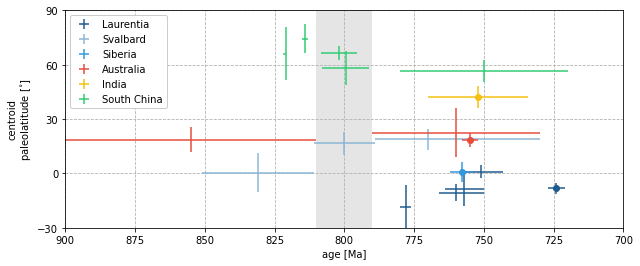

In [26]:
fig, ax = plt.subplots(figsize=(10,4))

xlim = [900, 700]

# Laurentia
df_slice = Laurentia_Laurentia[(Laurentia_Laurentia['age']<xlim[0]) & (Laurentia_Laurentia['age']>xlim[1])]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=Laurentia_color, label='Laurentia')
df_slice = Laurentia_Laurentia[(Laurentia_Laurentia['age']<xlim[0]) & (Laurentia_Laurentia['age']>xlim[1]) & (Laurentia_Laurentia['grade']=='A')]
ax.scatter(df_slice['age'], df_slice['centroid_lat'], color=Laurentia_color, label='__nolegend__', zorder=99)

# Svalbard
df_slice = Laurentia_Svalbard[(Laurentia_Svalbard['age']<xlim[0]) & (Laurentia_Svalbard['age']>xlim[1])]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=Svalbard_color, label='Svalbard')
df_slice = Laurentia_Svalbard[(Laurentia_Svalbard['age']<xlim[0]) & (Laurentia_Svalbard['age']>xlim[1]) & (Laurentia_Svalbard['grade']=='A')]
ax.scatter(df_slice['age'], df_slice['centroid_lat'], color=Svalbard_color, label='__nolegend__', zorder=99)

# Siberia
df_slice = Siberia[(Siberia['age']<xlim[0]) & (Siberia['age']>xlim[1])]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=Siberia_color, label='Siberia')
df_slice = Siberia[(Siberia['age']<xlim[0]) & (Siberia['age']>xlim[1]) & (Siberia['grade']=='A')]
ax.scatter(df_slice['age'], df_slice['centroid_lat'], color=Siberia_color, label='__nolegend__', zorder=99)

# Australia
df_slice = Australia[(Australia['age']<xlim[0]) & (Australia['age']>xlim[1])]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=Australia_color, label='Australia')
df_slice = Australia[(Australia['age']<xlim[0]) & (Australia['age']>xlim[1]) & (Australia['grade']=='A')]
ax.scatter(df_slice['age'], df_slice['centroid_lat'], color=Australia_color, label='__nolegend__', zorder=99)

# India
df_slice = India[(India['age']<xlim[0]) & (India['age']>xlim[1])]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=India_color, label='India')
df_slice = India[(India['age']<xlim[0]) & (India['age']>xlim[1]) & (India['grade']=='A')]
ax.scatter(df_slice['age'], df_slice['centroid_lat'], color=India_color, label='__nolegend__', zorder=99)

# SChina
df_slice = SChina_06[(SChina_06['age']<xlim[0]) & (SChina_06['age']>xlim[1]) & (SChina_06['name']!='Yanbian Dikes Group A')]
ax.errorbar(df_slice['age'], df_slice['centroid_lat'],
            yerr=df_slice['a95'], xerr=[df_slice['age lower diff'], df_slice['age upper diff']],
            fmt='none', color=SChina_color, label='South China')

# Bitter Springs
rect = patches.Rectangle((790,-90),
                         810-790,
                         180,
                         facecolor='C7',zorder=-999,alpha=0.2)
ax.add_patch(rect)

ax.set_ylim(-30,90)
ax.set_yticks(np.arange(-30,90+30,30))
ax.set_xlim(xlim)
ax.set_ylabel('centroid\npaleolatitude [$^{\circ}$]')
ax.grid(ls='--')
ax.set_xlabel('age [Ma]')
ax.legend(loc='upper left', framealpha=1)

plt.savefig('../Output/centroid_paleolatitudes.pdf', bbox_inches='tight')
plt.show(fig)

## South China APWP

APWP (f=1.0):

In [27]:
lat_grid=[-80,-60,-30,0,30,60,80]
lon_grid=np.arange(-180,180+60,60)

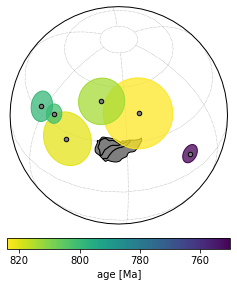

In [28]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                 figsize=(5,5), grid_lines=False)

craton_plot(ax, [6024], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [6023], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [602], [[0,0,0]], 'k', 'C7', 1.0)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_10['age']),
                                                         vmax=np.max(SChina_10['age'])))
colors = color_mapping.to_rgba(SChina_10['age']).tolist()

for i in range(len(SChina_10)):
    rotated_pole_plot(ax, SChina_10['plon'][i], SChina_10['plat'][i], SChina_10['a95'][i], [[0,0,0]],
                      'o', 20, 'C7', colors[i], 0.75)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_APWP_f_10.pdf', bbox_inches='tight')
plt.show()

APWP (f=0.6):

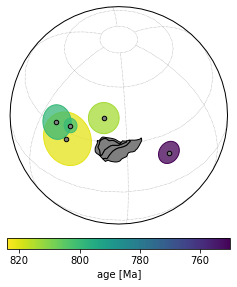

In [29]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                 figsize=(5,5), grid_lines=False)

craton_plot(ax, [6024], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [6023], [[0,0,0]], 'k', 'C7', 1.0)
craton_plot(ax, [602], [[0,0,0]], 'k', 'C7', 1.0)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_06['age']),
                                                         vmax=np.max(SChina_06['age'])))
colors = color_mapping.to_rgba(SChina_06['age']).tolist()

for i in range(1,len(SChina_06)):
    rotated_pole_plot(ax, SChina_06['plon'][i], SChina_06['plat'][i], SChina_06['a95'][i], [[0,0,0]],
                      'o', 20, 'C7', colors[i], 0.75)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_APWP_f_06.pdf', bbox_inches='tight')
plt.show()

Reconstructed South China (f=0.6):

In [30]:
# rotate SChina to India
SChina_India_Euler = [1.98, 74.44, 40.29]

# India rotations
India_Eulers = [[-47.7165, -59.0837, 80.611],
                [-50.9342, -61.1068, 78.6732],
                [-41.4357, -66.6919, 82.8756],
                [-66.5449, -2.2428, 80.9054]]

India_Eulers_ages = [821, 814, 801, 748]

# India rotations to plot the poles
India_Eulers_pole = [[-47.7165, -59.0837, 80.611],
                     [-50.9342, -61.1068, 78.6732],
                     [-41.4357, -66.6919, 82.8756],
                     [-41.4357, -66.6919, 82.8756],
                     [-66.5449, -2.2428, 80.9054]]

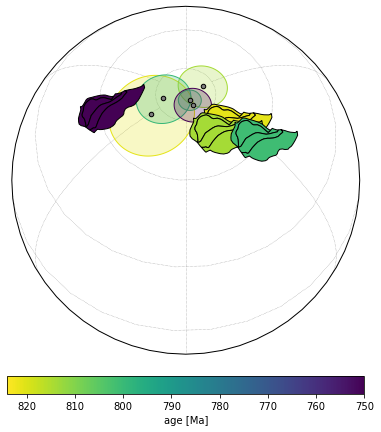

In [31]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=60, central_latitude=60,
                                 figsize=(8,8), grid_lines=False)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_06['age']),
                                                         vmax=np.max(SChina_06['age'])))
pole_colors = color_mapping.to_rgba(SChina_06['age']).tolist()
craton_colors = color_mapping.to_rgba(India_Eulers_ages).tolist()

for i in range(1, len(SChina_06)):
    rotated_pole_plot(ax, SChina_06['plon'][i], SChina_06['plat'][i], SChina_06['a95'][i],
                      [SChina_India_Euler,India_Eulers_pole[i-1]],
                      'o', 20, 'C7', pole_colors[i], 0.25)

for i in range(len(India_Eulers)):
    craton_plot(ax, [6024], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    craton_plot(ax, [6023], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    craton_plot(ax, [602], [SChina_India_Euler,India_Eulers[i]], 'k', craton_colors[i], 1.0)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_reconstructed.pdf', bbox_inches='tight')
plt.show()

## Australia-Siberia-Laurentia APWP

In [32]:
Laurentia_Euler_APWP           = [0, 0, 0]
Australia_Laurentia_Euler_APWP = [-33.8769, -31.5064, -131.3747]
Siberia_Laurentia_Euler_APWP   = [77.0, 98.0, 137.0]

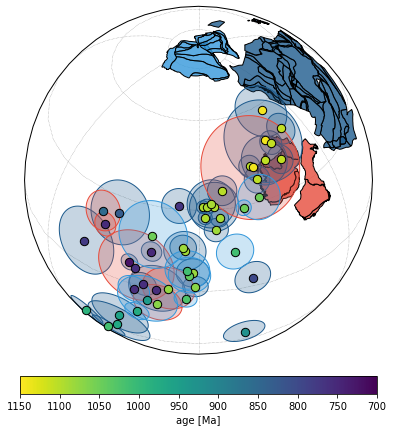

In [33]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=180, central_latitude=40,
                                 figsize=(8,8), grid_lines=False)

### CRATONS

# Laurentia
craton_plot(ax, [101], [Laurentia_Euler_APWP], 'k', Laurentia_color, 0.8)
craton_plot(ax, [303], [Laurentia_Euler_APWP, Euler_303], 'k', Laurentia_color, 0.8)
craton_plot(ax, [311], [Laurentia_Euler_APWP, Euler_311], 'k', Laurentia_color, 0.8)
craton_plot(ax, [107], [Laurentia_Euler_APWP, Euler_107], 'k', Laurentia_color, 0.8)

# Australia
craton_plot(ax, [801], [Australia_Laurentia_Euler_APWP, Laurentia_Euler_APWP], 'k', Australia_color, 0.8)
craton_plot(ax, [8011], [Euler_8011, Australia_Laurentia_Euler_APWP, Laurentia_Euler_APWP], 'k', Australia_color, 0.8)

# Siberia
craton_plot(ax, [401], [Siberia_Laurentia_Euler_APWP, Laurentia_Euler_APWP], 'k', Siberia_color, 0.8)
craton_plot(ax, [403], [Euler_403, Siberia_Laurentia_Euler_APWP, Laurentia_Euler_APWP], 'k', Siberia_color, 0.8)

### POLES

age_lim = [1150, 700]
color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=age_lim[1], vmax=age_lim[0]))

markersize = 70
alpha = 0.25

# Laurentia
df_slice = Laurentia[(Laurentia['age']<age_lim[0]) & (Laurentia['age']>age_lim[1])]
df_slice.reset_index(drop=True, inplace=True)
colors = color_mapping.to_rgba(df_slice['age']).tolist()
for i in range(len(df_slice)):
    if df_slice['plateID'][i]==101:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Laurentia_Euler_APWP],
                          'o', markersize, colors[i], Laurentia_color, alpha)
    elif df_slice['plateID'][i]==303:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Laurentia_Euler_APWP, Euler_303],
                          'o', markersize, colors[i], Laurentia_color, alpha)
    elif df_slice['plateID'][i]==311:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Laurentia_Euler_APWP, Euler_311],
                          'o', markersize, colors[i], Laurentia_color, alpha)
    elif df_slice['plateID'][i]==107:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Laurentia_Euler_APWP, Euler_107],
                          'o', markersize, colors[i], Laurentia_color, alpha)

# Australia
df_slice = Australia[(Australia['age']<age_lim[0]) & (Australia['age']>age_lim[1])]
df_slice.reset_index(drop=True, inplace=True)
colors = color_mapping.to_rgba(df_slice['age']).tolist()
for i in range(len(df_slice)):
    if df_slice['plateID'][i]==801:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Australia_Laurentia_Euler_APWP, Laurentia_Euler_APWP],
                          'o', markersize, colors[i], Australia_color, alpha)
    elif df_slice['plateID'][i]==8011:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Euler_8011, Australia_Laurentia_Euler_APWP, Laurentia_Euler_APWP],
                          'o', markersize, colors[i], Australia_color, alpha)
        
# Siberia
df_slice = Siberia[(Siberia['age']<age_lim[0]) & (Siberia['age']>age_lim[1])]
df_slice.reset_index(drop=True, inplace=True)
colors = color_mapping.to_rgba(df_slice['age']).tolist()
for i in range(len(df_slice)):
    if df_slice['plateID'][i]==401:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Siberia_Laurentia_Euler_APWP, Laurentia_Euler_APWP],
                          'o', markersize, colors[i], Siberia_color, alpha)
    elif df_slice['plateID'][i]==403:
        rotated_pole_plot(ax, df_slice['plon'][i], df_slice['plat'][i], df_slice['a95'][i],
                          [Euler_403, Siberia_Laurentia_Euler_APWP, Laurentia_Euler_APWP],
                          'o', markersize, colors[i], Siberia_color, alpha)
        
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

plt.savefig('../Output/Australia_Siberia_Laurentia_APWP.pdf', bbox_inches='tight')
plt.show()

## Paleogeographic Models

Reconstructing at 755 Ma, since there are 3 A-grade poles from Australia, India, and Siberia at this time.

### Missing Link

In [34]:
Laurentia_Euler_755            = [47.031, 153.0781, -183.4826]
Australia_Laurentia_Euler_755  = [-29.9108, -23.1709, -131.1567]
Antarctica_Australia_Euler_755 = [-3.91, 37.9, 30.86]
India_Euler_755                = [32.208, 178.1617, -23.636]
Rayner_India_Euler_755         = [1.8434, -165.1696, -91.8395]
SChina_India_Euler_755         = [-14.7197, 16.4551, -34.517]
Siberia_Laurentia_Euler_755    = [77.0, 98.0, 137.0]
Greenland_Laurentia_Euler_755  = [61.76, -132.95, -10.98]
Svalbard_Greenland_Euler_755   = [85.2803, 3.0787, -44.9407]

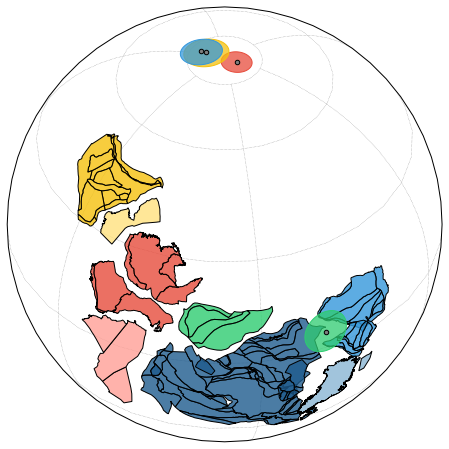

In [35]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=110, central_latitude=40,
                                 figsize=(8,8), grid_lines=False)

### CRATONS

# Laurentia
craton_plot(ax, [101], [Laurentia_Euler_755], 'k', Laurentia_color, 0.8)
craton_plot(ax, [107], [Laurentia_Euler_755, Euler_107], 'k', Laurentia_color, 0.8)
craton_plot(ax, [303], [Laurentia_Euler_755, Euler_303], 'k', Laurentia_color, 0.8)
craton_plot(ax, [311], [Laurentia_Euler_755, Euler_311], 'k', Laurentia_color, 0.8)

# Greenland
craton_plot(ax, [102], [Greenland_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Svalbard_color, 0.8)

# Svalbard
craton_plot(ax, [311], [Svalbard_Greenland_Euler_755, Greenland_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Svalbard_color, 0.8)

# Australia
craton_plot(ax, [801], [Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Australia_color, 0.8)
craton_plot(ax, [8011], [Euler_8011, Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Australia_color, 0.8)

# Australia
craton_plot(ax, [802], [Antarctica_Australia_Euler_755, Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Antarctica_color, 0.8)

# India
craton_plot(ax, [501], [India_Euler_755], 'k', India_color, 0.8)
craton_plot(ax, [5011], [India_Euler_755], 'k', India_color, 0.8)

# Rayner
craton_plot(ax, [803], [Rayner_India_Euler_755, India_Euler_755], 'k', Rayner_color, 0.8)

# Siberia
craton_plot(ax, [401], [Siberia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Siberia_color, 0.8)
craton_plot(ax, [403], [Euler_403, Siberia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Siberia_color, 0.8)

# South China
craton_plot(ax, [6024], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)
craton_plot(ax, [6023], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)
craton_plot(ax, [602], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)

### POLES

# Australia
df_slice = Australia[Australia['name']=='Mundine Well Dykes Combined']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [Australia_Laurentia_Euler_755, Laurentia_Euler_755],
                  'o', 20, 'C7', Australia_color, 0.75)

# India
df_slice = India[India['name']=='Malani Igneous Suite -Comb']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [India_Euler_755],
                  'o', 20, 'C7', India_color, 0.75)

# Siberia
df_slice = Siberia[Siberia['name']=='Kitoi Cryogenian dykes']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [Siberia_Laurentia_Euler_755, Laurentia_Euler_755],
                  'o', 20, 'C7', Siberia_color, 0.75)

# South China
df_slice = SChina_06[SChina_06['name']=='Liantuo Formation (f=0.6)']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [SChina_India_Euler_755, India_Euler_755],
                  'o', 20, 'C7', SChina_color, 0.75)

ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

plt.savefig('../Output/Missing_Link_model.pdf', bbox_inches='tight')
plt.show()

### Peripheral

In [36]:
Laurentia_Euler_755            = [47.031, 153.0781, -183.4826]
Australia_Laurentia_Euler_755  = [-29.9108, -23.1709, -131.1567]
Antarctica_Australia_Euler_755 = [-3.91, 37.9, 30.86]
India_Euler_755                = [32.208, 178.1617, -23.636]
Rayner_India_Euler_755         = [1.8434, -165.1696, -91.8395]
SChina_India_Euler_755         = [6.7224, 77.6921, 67.9571]
Siberia_Laurentia_Euler_755    = [77.0, 98.0, 137.0]
Greenland_Laurentia_Euler_755  = [61.76, -132.95, -10.98]
Svalbard_Greenland_Euler_755   = [85.2803, 3.0787, -44.9407]

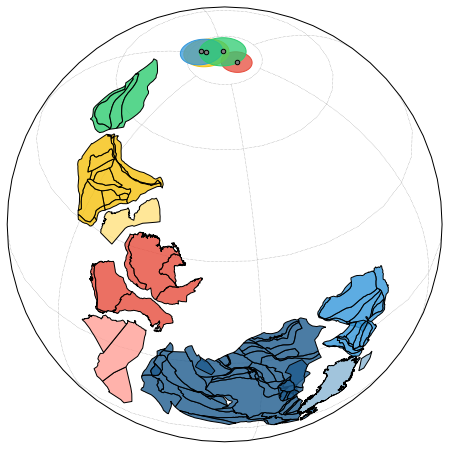

In [37]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=110, central_latitude=40,
                                 figsize=(8,8), grid_lines=False)

### CRATONS

# Laurentia
craton_plot(ax, [101], [Laurentia_Euler_755], 'k', Laurentia_color, 0.8)
craton_plot(ax, [107], [Laurentia_Euler_755, Euler_107], 'k', Laurentia_color, 0.8)
craton_plot(ax, [303], [Laurentia_Euler_755, Euler_303], 'k', Laurentia_color, 0.8)
craton_plot(ax, [311], [Laurentia_Euler_755, Euler_311], 'k', Laurentia_color, 0.8)

# Greenland
craton_plot(ax, [102], [Greenland_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Svalbard_color, 0.8)

# Svalbard
craton_plot(ax, [311], [Svalbard_Greenland_Euler_755, Greenland_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Svalbard_color, 0.8)

# Australia
craton_plot(ax, [801], [Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Australia_color, 0.8)
craton_plot(ax, [8011], [Euler_8011, Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Australia_color, 0.8)

# Australia
craton_plot(ax, [802], [Antarctica_Australia_Euler_755, Australia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Antarctica_color, 0.8)

# India
craton_plot(ax, [501], [India_Euler_755], 'k', India_color, 0.8)
craton_plot(ax, [5011], [India_Euler_755], 'k', India_color, 0.8)

# Rayner
craton_plot(ax, [803], [Rayner_India_Euler_755, India_Euler_755], 'k', Rayner_color, 0.8)

# Siberia
craton_plot(ax, [401], [Siberia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Siberia_color, 0.8)
craton_plot(ax, [403], [Euler_403, Siberia_Laurentia_Euler_755, Laurentia_Euler_755], 'k', Siberia_color, 0.8)

# South China
craton_plot(ax, [6024], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)
craton_plot(ax, [6023], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)
craton_plot(ax, [602], [SChina_India_Euler_755, India_Euler_755], 'k', SChina_color, 0.8)

### POLES

# Australia
df_slice = Australia[Australia['name']=='Mundine Well Dykes Combined']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [Australia_Laurentia_Euler_755, Laurentia_Euler_755],
                  'o', 20, 'C7', Australia_color, 0.75)

# India
df_slice = India[India['name']=='Malani Igneous Suite -Comb']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [India_Euler_755],
                  'o', 20, 'C7', India_color, 0.75)

# Siberia
df_slice = Siberia[Siberia['name']=='Kitoi Cryogenian dykes']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [Siberia_Laurentia_Euler_755, Laurentia_Euler_755],
                  'o', 20, 'C7', Siberia_color, 0.75)

# South China
df_slice = SChina_06[SChina_06['name']=='Liantuo Formation (f=0.6)']
rotated_pole_plot(ax, df_slice['plon'].iloc[0], df_slice['plat'].iloc[0], df_slice['a95'].iloc[0],
                  [SChina_India_Euler_755, India_Euler_755],
                  'o', 20, 'C7', SChina_color, 0.75)

ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

plt.savefig('../Output/periphery_model.pdf', bbox_inches='tight')
plt.show()